### CNN-LSTM_Attention Model

- 파이썬 버전: 3.8.18
- 생성 날짜: 2024.03.19

> __Attention__: 
모델이 입력 데이터의 중요한 부분에 더 많은 "주의"를 기울이도록 하여, 결과적으로 모델의 성능을 향상시킬 수 있음

### 1. Library 불러오기, SEED 설정, CUDA 사용

In [1]:
# 필요 라이브러리 import

# Pytorch
import torch
import torch.optim as optim
import torch.nn as nn

# Dataset 관련
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import sequence as sq # 사용자 정의 함수 불러오기

# 성능 평가 관련
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
from collections import Counter

# Visualization 관련
import matplotlib.pyplot as plt
import seaborn as sns

# 하이퍼파라미터 튜닝
import optuna
from optuna.pruners import MedianPruner
from sklearn.model_selection import TimeSeriesSplit

# 운영체제 관련
import platform

'''
딥러닝 학습을 진행할 때, 가중치를 임의의 값으로 초기화하여 학습을 수행하는 데, 
실험을 동일하게 진행하기 위해서는 난수를 동일하게 생성해야 한다.
Pytorch에서 random seed를 고정하기 위해 manual_seed를 사용한다.
'''

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# 운영체제별 device 설정
os_name = platform.system()
if os_name == 'Windows':
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"이 PC는 윈도우 운영 체제입니다: {device} is available")
elif os_name == 'Darwin':
    device = torch.device("mps" if torch.backends.mps.is_available else "cpu")
    print(f"이 PC는 맥(OS X) 운영 체제입니다: {device} is available")
else:
    print(f"이 PC는 다른 운영 체제입니다: {os_name}")


이 PC는 맥(OS X) 운영 체제입니다: mps is available


/opt/homebrew/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 2. 데이터 불러오기 및 전처리 (Binary, Scale, Tensor, train&valid&test split)

In [2]:
import pickle

# 불러오기
file_path = '../../data/'
seq_len = 20

with open(f'{file_path}X_train_seq_{seq_len}.pkl', 'rb') as file:
     X_train_seq= pickle.load(file)

with open(f'{file_path}X_val_seq_{seq_len}.pkl', 'rb') as file:
     X_val_seq= pickle.load(file)

with open(f'{file_path}X_test_seq_{seq_len}.pkl', 'rb') as file:
     X_test_seq= pickle.load(file)

with open(f'{file_path}y_train_seq_{seq_len}.pkl', 'rb') as file:
     y_train_seq= pickle.load(file)

with open(f'{file_path}y_val_seq_{seq_len}.pkl', 'rb') as file:
     y_val_seq= pickle.load(file)

with open(f'{file_path}y_test_seq_{seq_len}.pkl', 'rb') as file:
     y_test_seq= pickle.load(file)

print('Train Size:', X_train_seq.size(), y_train_seq.size())
print('Valid Size:', X_val_seq.size(), y_val_seq.size())
print('Test Size:', X_test_seq.size(), y_test_seq.size())

Train Size: torch.Size([66646, 20, 77]) torch.Size([66646, 1])
Valid Size: torch.Size([22215, 20, 77]) torch.Size([22215, 1])
Test Size: torch.Size([22216, 20, 77]) torch.Size([22216, 1])


In [3]:
# Dataset과 DataLoader를 이용해 배치 데이터로 만든다.
train = torch.utils.data.TensorDataset(X_train_seq, y_train_seq)
valid = torch.utils.data.TensorDataset(X_val_seq, y_val_seq)
test = torch.utils.data.TensorDataset(X_test_seq, y_test_seq)
batch_size = 128 # 32, 64, 128
train_loader =  torch.utils.data.DataLoader(dataset=train, batch_size=batch_size, shuffle=False, drop_last=True) # 시계열 데이터기에 shuffle X, 마지막 batch 버림
valid_loader = torch.utils.data.DataLoader(dataset=valid, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=batch_size, shuffle=False)


### 3. 모델 정의

In [4]:
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.attention = nn.Linear(hidden_size, 1)

    def forward(self, lstm_output):
        # LSTM 출력에 대한 attention 스코어 계산
        attention_weights = torch.softmax(self.attention(lstm_output), dim=1)
        # 가중치를 적용한 출력 계산
        context_vector = attention_weights * lstm_output
        context_vector = torch.sum(context_vector, dim=1)
        return context_vector, attention_weights

class CNNLSTMAttentionModel(nn.Module):
    # 기존 CNNLSTMModel 클래스 정의 부분은 동일하게 유지
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(CNNLSTMAttentionModel, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        
        # LSTM 레이어
        self.lstm = nn.LSTM(input_size=128, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes) # Fully Connected 레이어
        self.attention = Attention(hidden_size)  # Attention 레이어 추가

    def forward(self, x):
        # CNN 레이어 적용 (cnn takes input of shape (batch_size, channels, seq_len))
        x = x.permute(0, 2, 1)
        cnn_out = self.cnn(x)

        # LSTM 레이어 적용: lstm takes input of shape (batch_size, seq_len, input_size)
        input_lstm_out = cnn_out.permute(0, 2, 1)
        lstm_out, _ = self.lstm(input_lstm_out)

        # LSTM 출력을 Attention 레이어로 전달
        context_vector, attention_weights = self.attention(lstm_out)
        # Attention 적용 출력을 Fully Connected Layer로 전달
        out = self.fc(context_vector)
        return out, attention_weights  # Attention 가중치도 함께 반환

#model = CNNLSTMAttentionModel(input_size=77, hidden_size=64, num_layers=2, num_classes=1)
model = CNNLSTMAttentionModel(input_size=77, hidden_size=128, num_layers=2, num_classes=1)
model.to(device) # GPU 사용 시

CNNLSTMAttentionModel(
  (cnn): Sequential(
    (0): Conv1d(77, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (lstm): LSTM(128, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (attention): Attention(
    (attention): Linear(in_features=128, out_features=1, bias=True)
  )
)

Epoch 1/70, Train Loss: 0.005409108322643988, Valid Loss: 0.0054273524267621125
Epoch 2/70, Train Loss: 0.005406053232673737, Valid Loss: 0.005424777544205851
Epoch 3/70, Train Loss: 0.005389373402376154, Valid Loss: 0.005459147466894616
Epoch 4/70, Train Loss: 0.005227631498090725, Valid Loss: 0.0055137727977047305
Epoch 5/70, Train Loss: 0.005028357899185776, Valid Loss: 0.005193155177063679
Epoch 6/70, Train Loss: 0.00521966820942219, Valid Loss: 0.0051822263477816185
Epoch 7/70, Train Loss: 0.004664101039497942, Valid Loss: 0.0042986318329533615
Epoch 8/70, Train Loss: 0.004574641251311462, Valid Loss: 0.004401457338698871
Epoch 9/70, Train Loss: 0.0045565322984600365, Valid Loss: 0.0045031031186541165
Epoch 10/70, Train Loss: 0.004592065670136604, Valid Loss: 0.004477290389002937
Epoch 11/70, Train Loss: 0.004640593074830723, Valid Loss: 0.004485910049403877
Epoch 12/70, Train Loss: 0.004631220689377385, Valid Loss: 0.0049512805319922755
Epoch 13/70, Train Loss: 0.0046603068245654

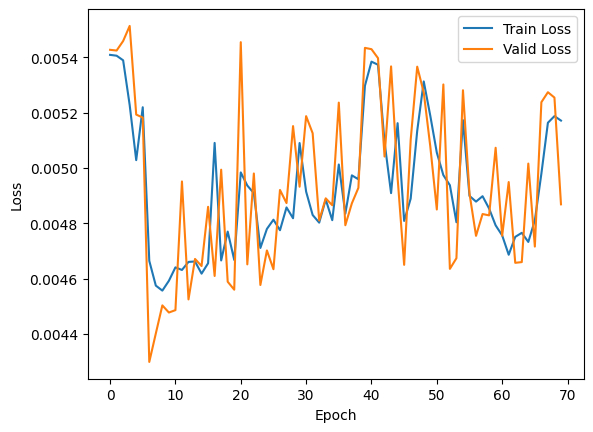

In [5]:
# 학습1: valid를 이용한 과적합 방지 epochs 찾기

# 학습과 검증 손실을 저장할 리스트 초기화
train_losses = []
valid_losses = []

# # 손실 함수와 옵티마이저 정의
criterion = nn.BCEWithLogitsLoss() # 시그모이드 활성화 함수가 내장되어 있음. 모델의 마지막 레이어에서 시그모이드 함수 별도 적용할 필요X
#criterion = nn.BCELoss() # 모델 출력이 시그모이드 활성화 함수를 거쳐 확률로 변환된 후의 값을 입력으로 받음. 입력 값은 0과 1사이의 확률 값.
optimizer = torch.optim.Adam(model.parameters(), lr=0.0002)


num_epochs = 100

# 검증 데이터에 대한 모델 성능 평가 함수 정의
def evaluate(model, criterion, dataloader):
    model.eval()  # 모델을 평가 모드로 설정
    total_loss = 0.0
    
    with torch.no_grad():
        for batch_features, batch_targets in dataloader:
            # 배치를 GPU로 전송
            batch_features, batch_targets = batch_features.to(device), batch_targets.to(device)
            
            # 모델에 대한 순전파 및 손실 계산
            #outputs = model(batch_features) *기존
            #loss = criterion(outputs, batch_targets) *기존
            outputs, attention_weights = model(batch_features)  # 모델의 반환값을 두 변수로 받음
            loss = criterion(outputs, batch_targets)  # 손실 함수에는 예측값만 전달

            
            total_loss += loss.item()
    
    return total_loss / len(dataloader.dataset)  # 평균 손실 반환

# 학습 루프
for epoch in range(num_epochs):
    model.train()  # 모델을 학습 모드로 설정
    total_loss = 0.0
    
    for batch_features, batch_targets in train_loader:
        # 배치를 GPU로 전송
        batch_features, batch_targets = batch_features.to(device), batch_targets.to(device)
        
        # 모델에 대한 순전파 및 손실 계산
        optimizer.zero_grad()
        #outputs = model(batch_features) *기존
        #loss = criterion(outputs, batch_targets) *기존
        outputs, attention_weights = model(batch_features)  # 모델의 반환값을 두 변수로 받음
        loss = criterion(outputs, batch_targets)  # 손실 함수에는 예측값만 전달

        
        # 역전파 및 최적화
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    # 에폭마다 학습 손실 기록
    train_loss = total_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    
    # 검증 데이터에 대한 손실 계산 및 기록
    valid_loss = evaluate(model, criterion, test_loader)
    valid_losses.append(valid_loss)
    
    # 에폭마다 손실 출력
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Valid Loss: {valid_loss}')

# 손실 함수 시각화
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [6]:

# '''
# 학습2: train data만 가지고 학습
# 이미 학습1 코드에서 모델이 학습을 수행하였으므로
# 학습2 코드 실행 전 재시작 -> 학습1 코드 실행 X -> 학습2 코드 실행(정해진 epochs만 학습)
# '''

# # 손실 함수와 옵티마이저 정의
# criterion = nn.BCEWithLogitsLoss()
# #criterion = nn.BCELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0008)

# batch_size = 128
# train_loader =  DataLoader(dataset=train, batch_size=batch_size, shuffle=False, drop_last=True) # 시계열 데이터기에 shuffle X, 마지막 batch 버림
# valid_loader = DataLoader(dataset=valid, batch_size=batch_size, shuffle=False)
# test_loader = DataLoader(dataset=test, batch_size=batch_size, shuffle=False)

# num_epochs = 80 # train, valid loss를 ㄴ기준으로 과적합되기 전 epochs

# # 학습 루프
# for epoch in range(num_epochs):
#     model.train()
#     total_loss = 0
    
#     for batch_features, batch_targets in train_loader:
#         # 배치를 GPU로 전송
#         batch_features, batch_targets = batch_features.to(device), batch_targets.to(device)
        
#         # 모델에 대한 순전파 및 손실 계산
#         optimizer.zero_grad()
#         #outputs = model(batch_features) *기존
#         #loss = criterion(outputs, batch_targets) *기존
#         outputs, attention_weights = model(batch_features)  # 모델의 반환값을 두 변수로 받음
#         loss = criterion(outputs, batch_targets)  # 손실 함수에는 예측값만 전달

        
#         # 역전파 및 최적화
#         loss.backward()
#         optimizer.step()
        
#         total_loss += loss.item()
    
#     # 에폭마다 손실 출력
#     print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss}')


In [7]:
# # 테스트 데이터 예측
# model.eval()  # 모델을 평가 모드로 설정
# y_true = []
# y_pred = []
# with torch.no_grad():
#     for x_batch, labels in test_loader:
#         x_batch = x_batch.to(device)
#         #outputs = model(x_batch) *기존
#         outputs, attention_weights = model(x_batch)  # 모델의 반환값을 두 변수로 받음
#         #loss = criterion(outputs, batch_targets)  # 손실 함수에는 예측값만 전달

#         # 로그 오즈를 확률로 변환
#         probs = torch.sigmoid(outputs).squeeze()

#         # 확률을 기준으로 0.5 이상이면 1, 미만이면 0으로 예측
#         preds = torch.round(probs).cpu().numpy()
#         y_true.extend(labels.squeeze().cpu().numpy())
#         y_pred.extend(preds)

# # 성능 지표 계산
# accuracy = accuracy_score(y_true, y_pred)
# precision = precision_score(y_true, y_pred)
# recall = recall_score(y_true, y_pred)
# f1 = f1_score(y_true, y_pred)

# # 결과 출력
# print(f'Data Imbalance: {Counter(y_true)}')
# print(f'Accuracy: {accuracy.round(4)}')
# print(f'Precision: {precision.round(4)}')
# print(f'Recall: {recall.round(4)}')
# print(f'F1 Score: {f1.round(4)}')

# # 혼동 행렬 출력
# conf_mat = confusion_matrix(y_true, y_pred)
# sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
# plt.xlabel('Predicted labels')
# plt.ylabel('True labels')
# plt.title(f'Confusion Matrix Sequence Length({seq_len})')
# plt.show()